In [1]:
import numpy as np
from pylab import *

import res_utils as ru
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'text.usetex': False})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.family': 'serif', 'font.serif':['Arial']})

np.set_printoptions(precision=3)

In [2]:
prime_set = []
for num in range(2,1901):
    for i in range(2,num):
        if (num%i==0):
            break
    else:
        prime_set.append(num)
print(prime_set)
n_factors = [3]
kappa_facs = np.flip([2.,4.])

hd_dims = np.round(2**np.arange(10,10.1,1.)).astype(int)
n_decs = ([1,3,7,15,31])

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541, 547, 557, 563, 569, 571, 577, 587, 593, 599, 601, 607, 613, 617, 619, 631, 641, 643, 647, 653, 659, 661, 673, 677, 683, 691, 701, 709, 719, 727, 733, 739, 743, 751, 757, 761, 769, 773, 787, 797, 809, 811, 821, 823, 827, 829, 839, 853, 857, 859, 863, 877, 881, 883, 887, 907, 911, 919, 929, 937, 941, 947, 953, 967, 971, 977, 983, 991, 997, 1009, 1013, 1019, 1021, 1031, 1033, 1039, 1049, 1051, 1061, 1063, 1069, 1087, 1091, 1093, 1097, 1103, 1109, 1117, 1123, 1129, 1151, 1153, 1163, 1171, 1181, 1187, 1193, 1201, 1213, 1217, 12

In [6]:
n_trials = 10

acc = np.zeros((len(n_decs),len(kappa_facs),len(hd_dims),len(prime_set)-1))
acc[:] = np.nan
breaks = np.ones((len(n_decs),len(kappa_facs),len(hd_dims)))*(n_trials)
track_n_iters = np.zeros((len(kappa_facs),len(hd_dims),len(prime_set)-1,n_trials))
track_n_iters[:] = np.nan
tic = time.perf_counter()
nb = n_factors[0]

for b in range(len(n_decs)):
    bindigs = n_decs[b]
    for h in range(len(kappa_facs)):
        kb = kappa_facs[h]
    #     nb = n_factors[h]
        for i in range(len(hd_dims)):
            v_size = hd_dims[i]
            for j in range(0,len(prime_set)-(nb-1)):
                bases = prime_set[j:j+nb]

                base_size = 1
                for m in range(len(bases)):
                    base_size *= bases[m]
                acc[b,h,i,j] = 0
                for k in range(n_trials):
                    seed_vecs = []
                    for m in range(len(bases)):
                        seed_vecs.append(ru.cvecl(v_size, loopsize=bases[m]))

                    codebooks = []
                    for m in range(len(bases)):
                        samp_code = np.random.normal(0.0,1.0,size=(bases[m],v_size)) + 1j*np.random.normal(0.0,1.0,size=(bases[m],v_size))
                        samp_code = samp_code*0
                        codebooks.append(samp_code)

                    for m in range(len(bases)):
                        for n in range(bases[m]):
                            codebooks[m][n,:] = np.power(seed_vecs[m],n)

                    resonator = np.ones((len(bases),v_size),dtype=complex)
                    for m in range(len(codebooks)):
                        resonator[m,:] = np.random.normal(0.0,1.0,size=(1,v_size)) + 1j*np.random.normal(0.0,1.0,size=(1,v_size))
                        resonator[m,:] = resonator[m,:]/ np.abs(resonator[m,:])

                    num_iters = 50
                    samp_range = 1
                    for m in range(len(bases)):
                        samp_range *= bases[m]
                    key = np.random.randint(0,samp_range)
                    bm = np.random.randint(0,bindigs)
                    scene = np.ones((v_size,),dtype=complex)
                    for m in range(len(bases)):
                        scene *= np.power(seed_vecs[m],(key + bm/bindigs))
                    
                    if not np.isnan(kb):
                        noise = np.random.vonmises(0,kb,size=scene.size)
                        scene = np.exp(1j * (np.angle(scene)+noise))
                    n_updates, res_hist = ru.gen_res_digit(resonator,codebooks,num_iters,scene)

                    progs = []
                    for m in range(len(bases)):
                        c = codebooks[m]
                        corrs = np.zeros((n_updates+1,c.shape[0]),dtype=complex)
                        for n in range(n_updates,n_updates+1):
                            for p in range(c.shape[0]):
                                corrs[n,p] = ru.dot_complex(res_hist[n][m,:],codebooks[m][p,:])

                        progs.append(corrs)
                    is_correct = 1
                    for m in range(len(progs)):
                        is_correct *= (np.argmax(progs[m][-1,:]) == np.rint(key+bm/bindigs) % bases[m])
                        
                        subint_vecs = np.zeros((bindigs,v_size),dtype=complex)
                        for bn in range(bindigs):
                            subint_vecs[bn,:] = np.power(seed_vecs[m],(key + bn/bindigs))
                        
                        correct_sub = ru.dot_complex(res_hist[n][m,:],subint_vecs.T)
                        is_correct *= (np.argmax(correct_sub) == bm)
                        
                    acc[b,h,i,j] += is_correct
                    track_n_iters[h,i,j,k] = n_updates 
                toc = time.perf_counter()
                print(bindigs,kb,v_size,base_size,acc[b,h,i,j]/n_trials,np.sum(track_n_iters[h,i,j,:])/n_trials,toc-tic)
                tic = toc
                if(j > 2 and (acc[b,h,i,j]/n_trials) < 0.02):
                    breaks[b,h,i] = j
                    break

1 4.0 1024 30 1.0 3.0 0.020902124932035804
1 4.0 1024 105 1.0 3.3 0.01845541608054191
1 4.0 1024 385 1.0 3.4 0.02909912494942546
1 4.0 1024 1001 1.0 4.3 0.027897499967366457
1 4.0 1024 2431 1.0 5.0 0.03856875002384186
1 4.0 1024 4199 1.0 4.5 0.03997304197400808
1 4.0 1024 7429 0.9 5.5 0.05432362505234778
1 4.0 1024 12673 0.8 5.4 0.055016833008266985
1 4.0 1024 20677 0.9 6.5 0.06195312493946403
1 4.0 1024 33263 0.8 5.8 0.06706791708711535
1 4.0 1024 47027 0.4 7.0 0.08198612497653812
1 4.0 1024 65231 0.4 7.3 0.08394083299208432
1 4.0 1024 82861 0.3 6.9 0.08610079193022102
1 4.0 1024 107113 0.0 6.6 0.09412333299405873
1 2.0 1024 30 1.0 3.0 0.013775084051303566
1 2.0 1024 105 1.0 3.2 0.015935749979689717
1 2.0 1024 385 1.0 3.7 0.022061833064071834
1 2.0 1024 1001 1.0 4.1 0.028034541988745332
1 2.0 1024 2431 0.9 4.9 0.03614541597198695
1 2.0 1024 4199 1.0 4.9 0.03967762493994087
1 2.0 1024 7429 1.0 6.3 0.04990575008559972
1 2.0 1024 12673 0.8 6.8 0.062283291947096586
1 2.0 1024 20677 0.6 7.

In [7]:
def Isymb(a,D,q):
    Dq = D*q
    arg1= a*np.log2(Dq**a)
    arg1[np.isnan(arg1)] = 0
    
    arg2 = (1-a)*np.log2((1-a)*Dq/(Dq-1))
    arg2[np.isnan(arg2)] = 0
    
    return arg1+arg2

/var/folders/zc/f1yph2j5477fj51bpj7q0dl80000gp/T/ipykernel_5945/4067025914.py:6: RuntimeWarning: divide by zero encountered in log2
  arg2 = (1-a)*np.log2((1-a)*Dq/(Dq-1))
/var/folders/zc/f1yph2j5477fj51bpj7q0dl80000gp/T/ipykernel_5945/4067025914.py:6: RuntimeWarning: invalid value encountered in multiply
  arg2 = (1-a)*np.log2((1-a)*Dq/(Dq-1))


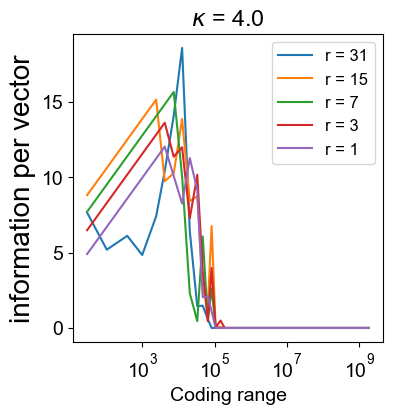

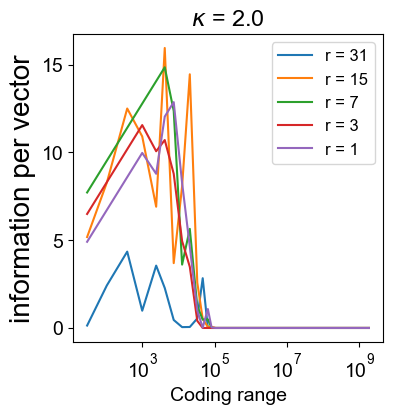

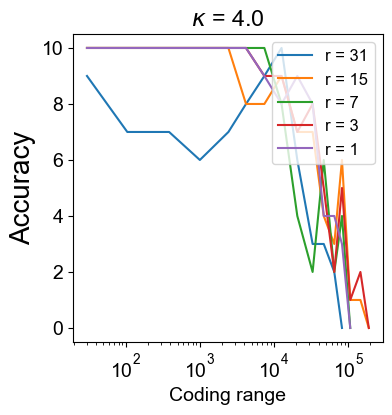

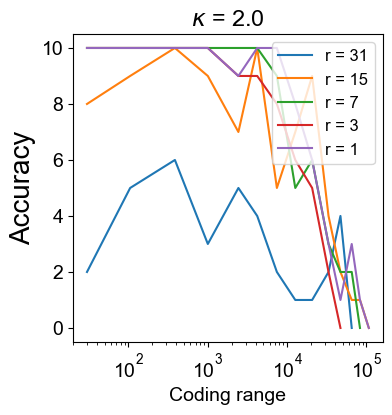

In [9]:
capacity = []
for i in range(len(kappa_facs)):
    cap_factor = []
    for j in range(len(prime_set)-6):
        part = 1
        for k in range(nb):
            part *= prime_set[j+k]
        cap_factor.append(part)
    capacity.append(cap_factor)
    
for j in range(len(kappa_facs)):
    figure(figsize=(4,4))
    title(r'$\kappa$ = ' + str(kappa_facs[j])+'')
    for i in np.flip(range(len(n_decs))):
        plot(capacity[0][0:200],Isymb(acc[i,j,0,0:200]/n_trials,np.asarray(capacity[0][0:200]),n_decs[i]),'-',label='r = ' + str(n_decs[i]))

    xscale('log')
    legend(fontsize=12,loc='upper right')
    xlabel('Coding range')
    ylabel('information per vector',fontsize=20)
    
for j in range(len(kappa_facs)):
    figure(figsize=(4,4))
    title(r'$\kappa$ = ' + str(kappa_facs[j])+'')
    for i in np.flip(range(len(n_decs))):
        plot(capacity[0][0:200],acc[i,j,0,0:200],'-',label='r = ' + str(n_decs[i]))

    xscale('log')
    legend(fontsize=12,loc='upper right')
    xlabel('Coding range')
    ylabel('Accuracy',fontsize=20)